In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact_manual


In [2]:
#lets read the dataset
df=pd.read_csv('movie_metadata.csv')

In [3]:
#Lets cheack shape of dataset
df.shape

(5043, 28)

In [4]:
#lets cheack columns 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [5]:
#lets remove the unwanted columns
df.drop(['director_facebook_likes', 
         'actor_1_facebook_likes',
         'actor_3_facebook_likes',
         'cast_total_facebook_likes',
         'facenumber_in_poster',
         'movie_imdb_link',
        'color',
         'content_rating',
         'actor_2_facebook_likes',
         'aspect_ratio', 
         'plot_keywords',
         'country'],axis=1,inplace=True)

In [6]:
df.columns

Index(['director_name', 'num_critic_for_reviews', 'duration', 'actor_2_name',
       'gross', 'genres', 'actor_1_name', 'movie_title', 'num_voted_users',
       'actor_3_name', 'num_user_for_reviews', 'language', 'budget',
       'title_year', 'imdb_score', 'movie_facebook_likes'],
      dtype='object')

In [7]:
#lets cheack the percentage of missing values in each column
round((df.isnull().sum()/df.shape[0])*100,2)

director_name              2.06
num_critic_for_reviews     0.99
duration                   0.30
actor_2_name               0.26
gross                     17.53
genres                     0.00
actor_1_name               0.14
movie_title                0.00
num_voted_users            0.00
actor_3_name               0.46
num_user_for_reviews       0.42
language                   0.24
budget                     9.76
title_year                 2.14
imdb_score                 0.00
movie_facebook_likes       0.00
dtype: float64

In [8]:
#deleting the rows in gross and budget column where missing valulues are present
df=df[~df['gross'].isnull()]
df=df[~df['budget'].isnull()]
df.isnull().sum()

director_name              0
num_critic_for_reviews     1
duration                   1
actor_2_name               5
gross                      0
genres                     0
actor_1_name               3
movie_title                0
num_voted_users            0
actor_3_name              10
num_user_for_reviews       0
language                   3
budget                     0
title_year                 0
imdb_score                 0
movie_facebook_likes       0
dtype: int64

In [9]:
#imputing Missing values
df['num_critic_for_reviews'].fillna(df['num_critic_for_reviews'].mean(),inplace=True)
df['duration'].fillna(df['duration'].mean(),inplace=True)
df['language'].fillna(df['language'].mode()[0],inplace=True)
df['actor_1_name'].fillna('Unknown Actor',inplace=True)
df['actor_2_name'].fillna('Unknown Actor',inplace=True)
df['actor_3_name'].fillna('Unknown Actor',inplace=True)
df.isnull().sum().sum()


0

### Feature Engineering

In [10]:
#calculating profit for movies
df['profit']=df['gross']-df['budget']
df.drop_duplicates(subset=None,keep='first',inplace=True)

df[['movie_title','profit']].sort_values(by='profit',ascending=False).head(11).reset_index(drop=True).style.background_gradient('copper')

,movie_title,profit
0,Avatar,523505847.000000
1,Jurassic World,502177271.000000
2,Titanic,458672302.000000
3,Star Wars: Episode IV - A New Hope,449935665.000000
4,E.T. the Extra-Terrestrial,424449459.000000
5,The Avengers,403279547.000000
6,The Lion King,377783777.000000
7,Star Wars: Episode I - The Phantom Menace,359544677.000000
8,The Dark Knight,348316061.000000
9,The Hunger Games,329999255.000000


####  Manipulating the Language and Duration Column

In [11]:
def language(x):
    if x=='English':
        return 'English'
    else:
        return 'Foreign'
df['language']=df['language'].apply(language)
df['language'].value_counts()


English    3676
Foreign     180
Name: language, dtype: int64

In [12]:
def Duration(x):
    if x<=120:
        return 'short Movies'
    else:
        return 'long Movies'
#df['duration']=df['duration'].astype(int)
df['duration']=df['duration'].apply(Duration)
df['duration'].value_counts()

short Movies    2939
long Movies      917
Name: duration, dtype: int64

####                   Extracting Movie Genres


In [13]:
df['genres'].value_counts()

Drama                                     153
Comedy|Drama|Romance                      151
Comedy|Drama                              147
Comedy                                    145
Comedy|Romance                            135
                                         ... 
Action|Crime|Drama|Thriller|War             1
Adventure|Comedy|Family|Musical             1
Action|Adventure|Family|Fantasy|Sci-Fi      1
Action|Drama|Mystery|Thriller|War           1
Comedy|Crime|Horror                         1
Name: genres, Length: 762, dtype: int64

In [14]:
# as most of the movies have more than one genres we create separate columns for each genres
df['genres']=df['genres'].astype(str)# converting column dataype float to string
df['genres']=df['genres'].str.split('|')
df['genre1']=df['genres'].apply(lambda x: x[0])
df['genre2']=df['genres'].apply(lambda x:x[1] if len(x)>1 else x[0])
df['genre3']=df['genres'].apply(lambda x:x[2] if len(x)>2 else x[0])
df['genre4']=df['genres'].apply(lambda x:x[3] if len(x)>3 else x[0])

df.columns

Index(['director_name', 'num_critic_for_reviews', 'duration', 'actor_2_name',
       'gross', 'genres', 'actor_1_name', 'movie_title', 'num_voted_users',
       'actor_3_name', 'num_user_for_reviews', 'language', 'budget',
       'title_year', 'imdb_score', 'movie_facebook_likes', 'profit', 'genre1',
       'genre2', 'genre3', 'genre4'],
      dtype='object')

#### Lets calculate social media popularity of a Movie

In [15]:
#To calculate social media popularity we using ratio of 'total no of people who reviwed movie 'and 'no of people who reviwed for movie' 

#and multiplying it by facebook likes
df['socialmedia_popularity']=(df['num_user_for_reviews']/df['num_user_for_reviews'])*df['movie_facebook_likes']
x=df[['movie_title','socialmedia_popularity']].sort_values(by='socialmedia_popularity',ascending=False).head(10).reset_index(drop=True)
x

,movie_title,socialmedia_popularity
0,Interstellar,349000.0
1,Django Unchained,199000.0
2,Batman v Superman: Dawn of Justice,197000.0
3,Mad Max: Fury Road,191000.0
4,The Revenant,190000.0
5,Inception,175000.0
6,The Hobbit: An Unexpected Journey,166000.0
7,The Imitation Game,165000.0
8,The Dark Knight Rises,164000.0
9,The Martian,153000.0


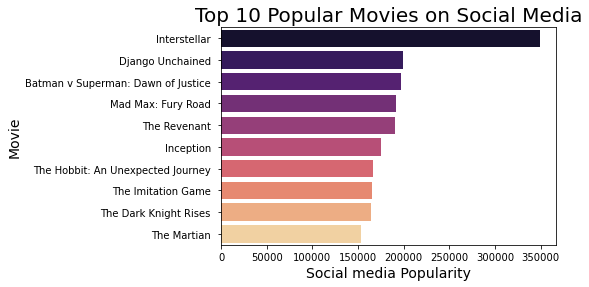

In [16]:
#visualizing the top 10 movies popular on social media
sns.barplot(y=x['movie_title'],x=x['socialmedia_popularity'],palette='magma')
plt.rcParams['figure.figsize']=(10,4)
plt.xlabel('Social media Popularity',fontsize=14)
plt.ylabel("Movie",fontsize=14)
plt.title('Top 10 Popular Movies on Social Media',fontsize=20)
plt.show()

#### Most Bankable Genres

In [17]:
df[['genre1','gross']].groupby('genre1').agg(['min','mean','max']).style.background_gradient('inferno')

#### Analyzing the Most profitable movies

In [18]:
df[['genre1','movie_title','profit']].groupby(['genre1','movie_title']).agg('sum').sort_values(by='profit',ascending=False).style.background_gradient('copper')

In [19]:
#Analyzing Most profitable years in Box office
df['title_year']=df['title_year'].astype('int')
df['title_year'] = pd.to_datetime(df['title_year'].astype(str), format='%Y').dt.year
df[['title_year','language','profit']].groupby(['language','title_year']).agg('sum').sort_values(by='profit',ascending=False).head(10).style.background_gradient('Greens')

C:\Users\prasad bolgss\anaconda4\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


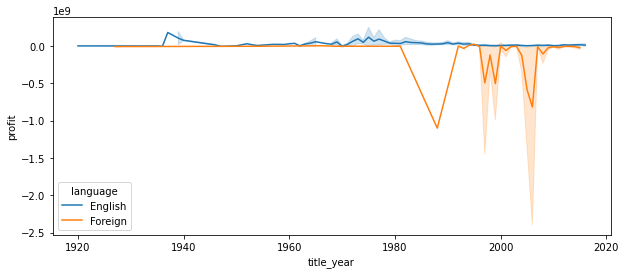

In [20]:
#lets plot the profit of english and foreign movies
sns.lineplot(df['title_year'],df['profit'],hue=df['language'])
plt.show()



In [21]:
#foreign movies which made huge losses
df[df['language']=='Foreign'][['movie_title','language','profit']].sort_values(by='profit',ascending=True).reset_index(drop=True).head(10).style.background_gradient('copper')

,movie_title,language,profit
0,The Host,Foreign,-12213298588.000000
1,Lady Vengeance,Foreign,-4199788333.000000
2,Fateless,Foreign,-2499804112.000000
3,Princess Mononoke,Foreign,-2397701809.000000
4,Steamboy,Foreign,-2127109510.000000
5,Akira,Foreign,-1099560838.000000
6,Godzilla 2000,Foreign,-989962610.000000
7,Tango,Foreign,-698312689.000000
8,Kabhi Alvida Naa Kehna,Foreign,-696724557.000000
9,Red Cliff,Foreign,-553005191.000000


#### Comparison of long and short movies

In [22]:
pd.options.display.float_format = '{:.0f}'.format
df[['movie_title','duration','gross','profit']].groupby('duration').sum().style.background_gradient('Greens')


,gross,profit
duration,,
long Movies,75282492903.000000,13253388510.000000
short Movies,121075363848.000000,8783775460.000000


In [23]:
#most profitable long movies
df[df['duration']=='long Movies'][['movie_title','duration','gross','profit']].sort_values(by='gross',ascending=False).head(5).style.background_gradient('spring')

,movie_title,duration,gross,profit
0,Avatar,long Movies,760505847.000000,523505847.000000
26,Titanic,long Movies,658672302.000000,458672302.000000
29,Jurassic World,long Movies,652177271.000000,502177271.000000
17,The Avengers,long Movies,623279547.000000,403279547.000000
66,The Dark Knight,long Movies,533316061.000000,348316061.000000


In [24]:
#most profitable short movies
df[df['duration']=='short Movies'][['movie_title','duration','gross','profit']].sort_values(by='gross',ascending=False).head(5).style.background_gradient('spring')

,movie_title,duration,gross,profit
582,Shrek 2,short Movies,436471036.000000,286471036.000000
3080,E.T. the Extra-Terrestrial,short Movies,434949459.000000,424449459.000000
509,The Lion King,short Movies,422783777.000000,377783777.000000
43,Toy Story 3,short Movies,414984497.000000,214984497.000000
125,Frozen,short Movies,400736600.000000,250736600.000000


<AxesSubplot:xlabel='duration', ylabel='gross'>

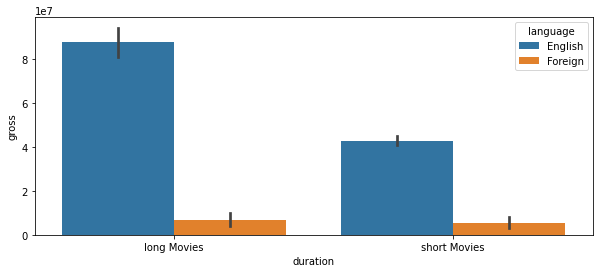

In [25]:
#lets understand effect of duration on the gross for different languages
sns.barplot(y=df['gross'],x=df['duration'],hue=df['language'])

#### Association between IMDB rating and duration

In [26]:
# Average of the imdb scores of long movies
df[df['duration']=='long Movies']['imdb_score'].mean()

7.059432933478736

In [27]:
# Average of the imdb scores of short movies
df[df['duration']=='short Movies']['imdb_score'].mean()

6.278087784960868

In [28]:
#long movie with highest imdb score
df[df['duration']=='long Movies'][['movie_title','imdb_score']].sort_values(by='imdb_score',ascending=False).head(1)

,movie_title,imdb_score
1937,The Shawshank Redemption,9


In [29]:
#short movie with highest imdb score
df[df['duration']=='short Movies'][['movie_title','imdb_score']].sort_values(by='imdb_score',ascending=False).head(1)

,movie_title,imdb_score
3592,The Usual Suspects,9


<AxesSubplot:xlabel='imdb_score', ylabel='duration'>

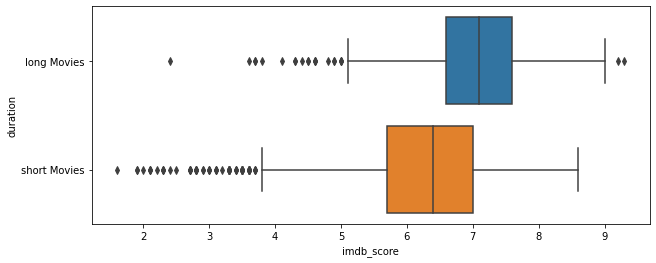

In [30]:
sns.boxplot(y=df['duration'],x=df['imdb_score'])

#### Comparing critically aclaimed actors

In [31]:
def actors(x):
    act=df[(df['actor_1_name']==x)|(df['actor_2_name']==x)|(df['actor_3_name']==x)]
    return act[['movie_title','budget','gross','title_year','genres','language','imdb_score']]


In [32]:
actors('Meryl Streep')

,movie_title,budget,gross,title_year,genres,language,imdb_score
410,It's Complicated,85000000,112703470,2009,"[Comedy, Drama, Romance]",English,7
860,Death Becomes Her,55000000,58422650,1992,"[Comedy, Fantasy, Horror]",English,6
914,Mamma Mia!,52000000,143704210,2008,"[Comedy, Family, Musical, Romance]",English,6
945,Into the Woods,50000000,127997349,2014,"[Adventure, Comedy, Drama, Fantasy, Musical]",English,6
1106,The River Wild,45000000,46815748,1994,"[Action, Adventure, Crime, Thriller]",English,6
1111,The Ant Bully,50000000,28133159,2006,"[Adventure, Animation, Comedy, Family, Fantasy]",English,6
1204,Julie & Julia,40000000,94125426,2009,"[Biography, Drama, Romance]",English,7
1295,Fantastic Mr. Fox,40000000,20999103,2009,"[Adventure, Animation, Comedy, Crime, Family]",English,8
1408,The Devil Wears Prada,35000000,124732962,2006,"[Comedy, Drama, Romance]",English,7
1483,Lions for Lambs,35000000,14998070,2007,"[Drama, Thriller, War]",English,6


In [33]:
def actor_reports(x):
    actr=df[(df['actor_1_name']==x)|(df['actor_2_name']==x)|(df['actor_3_name']==x)]
    print('time:',actr['title_year'].min(),df['title_year'].max())
    print('Max gross:',round((actr['gross'].max()/1000000),2),'millions\n',
         'Average gross:',round((actr['gross'].mean()/1000000),2),'millions\n',
         'Minimum gross:',round((actr['gross'].min()/1000000),2),'millions\n',
         'no of Movies crossed 1 million:',actr[actr['gross']>1000000].shape[0],'\n',
         'Aerage Imdb rating:',round(actr['imdb_score'].mean(),2))
    print(actr['genre1'].value_counts())


In [34]:
actor_reports('Meryl Streep')

time: 1985 2016
Max gross: 143.7 millions
 Average gross: 55.23 millions
 Minimum gross: 9.66 millions
 no of Movies crossed 1 million: 23 
 Aerage Imdb rating: 6.81
Drama        9
Comedy       7
Adventure    3
Biography    3
Action       1
Name: genre1, dtype: int64


In [35]:
#Creating function to campare critically aclaimed actors
def critically_aclaimed_actors(x):
    cact=df[(df['actor_1_name']==x)|(df['actor_2_name']==x)|(df['actor_3_name']==x)]
    return print('Number of critic reviews for ',x,'is',cact['num_critic_for_reviews'].sum().astype(int))
 


In [36]:
critically_aclaimed_actors('Brad Pitt')

Number of critic reviews for  Brad Pitt is 7814


#### Creating interactive function to filter movies on basis of imbd score

In [37]:
@interact
def movies_imdb(score=df['imdb_score'].sort_values().unique()):
    im=df[df['imdb_score']>score][['title_year','movie_title','imdb_score']].reset_index(drop=True)
    return im

interactive(children=(Dropdown(description='score', options=(1.6, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.7, 2.8,…

In [38]:
# Creating interactive function filter movies based on budget and gross
pd.set_option('display.max_rows',3000)
@interact
def finacial_report(column=['budget','gross'],amount=df['budget'].max()):
    fr=df[df[column]>amount][['movie_title','budget','gross']]
    return fr


interactive(children=(Dropdown(description='column', options=('budget', 'gross'), value='budget'), FloatSlider…

### Building Recommedation engine

In [39]:
# Recommenadtion of movies based on language and imdb score
@interact
def recom_imdb(language=df['language'].unique(),score=df['imdb_score'].sort_values().unique()):
    data=df[(df['language']==language)&(df['imdb_score']>score)][['movie_title','language','imdb_score']].head(100).sort_values(by='imdb_score',ascending=False)
    return data

interactive(children=(Dropdown(description='language', options=('English', 'Foreign'), value='English'), Dropd…

In [40]:
# Recommedation of movies based on actors 
def recom_act(x):
    data=df[(df['actor_1_name']==x)|(df['actor_2_name']==x)|(df['actor_3_name']==x)][['movie_title','language','imdb_score']]
    return data.sort_values(by='imdb_score',ascending=False)


In [41]:
recom_act('Tom Cruise')

,movie_title,language,imdb_score
1868,Rain Man,English,8
75,Edge of Tomorrow,English,8
158,The Last Samurai,English,8
284,Minority Report,English,8
1524,A Few Good Men,English,8
940,Interview with the Vampire: The Vampire Chroni...,English,8
736,Collateral,English,8
155,Mission: Impossible - Ghost Protocol,English,7
135,Mission: Impossible - Rogue Nation,English,7
930,Jerry Maguire,English,7


In [42]:
df[df['title_year']==2008][['movie_title','gross']].sort_values(by='gross',ascending=False)
df[df['language']=='Foreign'][['movie_title','gross']].sort_values(by='gross',ascending=False)

,movie_title,gross
2605,"Crouching Tiger, Hidden Dragon",128067808
4024,March of the Penguins,77413017
377,The Interpreter,72515360
1236,Apocalypto,50859889
484,The Legend of Zorro,45356386
3705,Instructions Not Included,44456509
2551,Pan's Labyrinth,37623143
1298,Amélie,33201661
3436,Rumble in the Bronx,32333860
4000,The Secret in Their Eyes,20167424


#### Recommedation of movies on the basis of genres

In [43]:
from mlxtend.preprocessing import TransactionEncoder 
#df['genres']
x=df['genres'].astype('str')
x=df['genres'].tolist()# transform encoder need list for ecoding
#x = [eval(item) for item in x]
te=TransactionEncoder()
te.fit(x)
x=te.transform(x)
x=pd.DataFrame(x,columns=te.columns_)


In [44]:
genres=x.astype(int)

In [45]:
genres.insert(0,'movie_title',df['movie_title'])
genres=genres.set_index('movie_title')
genres

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
movie_title,,,,,,,,,,,,,,,,,,,,,
Avatar,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
Pirates of the Caribbean: At World's End,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Spectre,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
The Dark Knight Rises,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
NaN,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tango,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Moms' Night Out,1,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0


In [46]:
#creating function to recommend similar genres
def recommedation_genres(gen):
    genre= genres[gen]
    similar_genres=genres.corrwith(genre)
    similar_genres=similar_genres.sort_values(ascending=False)
    similar_genres = similar_genres.iloc[1:].apply('{:.4f}'.format)  # Format values with four decimal places
    return similar_genres.head(3)

In [47]:
recommedation_genres('Action')

Adventure    0.3207
Thriller     0.3039
Sci-Fi       0.2951
dtype: object

In [48]:
#as movie title consist of some dirty values we must clean it
genres.index=genres.index.str.replace('\xa0','')
genres.index[0]

'Avatar'

In [49]:
x=genres.transpose()


In [50]:
#creating function to recommend similar movies
def similar_movies(movie):
    Movie=x[movie]
    Similar_Movies=x.corrwith(Movie).sort_values(ascending=False)
   # Similar_Movies=Similar_Movies.iloc[1:0]
    return Similar_Movies.head(20)

In [51]:
similar_movies('The Dark Knight Rises')

movie_title
High Heels and Low Lifes                1
The Lord of the Rings: The Two Towers   1
Jonah: A VeggieTales Movie              1
The Nut Job                             1
America's Sweethearts                   1
Monkeybone                              1
The 13th Warrior                        1
Sex and the City 2                      1
The Ghost and the Darkness              1
Scarface                                1
The Angry Birds Movie                   1
Into the Blue                           1
Firefox                                 1
The Beach                               1
Barnyard                                1
The Adjustment Bureau                   1
Hitch                                   1
Driven                                  1
The Dark Knight Rises                   1
The Truman Show                         1
dtype: float64

In [52]:
df['movie_title']=df['movie_title'].str.replace('\xa0','')
x=['A separation','Spirited Away','City of God',"Pan's Labyrinth"]
df.loc[df['movie_title'].isin(x),['movie_title','gross']]

,movie_title,gross
2373,Spirited Away,10049886
2551,Pan's Labyrinth,37623143
4029,City of God,7563397
